# Zip-dLBM: Simplest Functional Notebook

This notebook implements a minimal, runnable version of the Zero-Inflated Dynamic Latent Block Model (Zip-dLBM).
It mirrors the data handling in `Script-LondonBikes.R`, then fits a simplified dynamic co-clustering model.


## Phase 1: Planning and Analysis

**How `Script-LondonBikes.R` loads and preprocesses data**
- Reads four local XLSX files from `./data/` and row-binds them.
- Parses `Start Date`, sorts by time, filters to a June 2022 window.
- Filters to hours 06-21, creates hour labels and an hour ID.
- Keeps stations with more than 50 trips both as start and end.
- Converts station names to integer IDs, keeps weekdays only.
- Builds a 3D tensor `D` of shape (N, P, U) by counting trips for each start, end, and hour.

**Python porting strategy**
- Use `pandas.read_excel` to load all XLSX files.
- Apply the same filters with pandas: date range, hour range, weekdays, station frequency.
- Build a dense tensor with `numpy.add.at` using index arrays.

**Simplification strategy**
- Use a small number of clusters (`Q=3`, `L=3`).
- Use a short time window (few hours) to keep runtime low.
- Use small MLPs and a simple Euler ODE solver.
- Run only a few EM iterations and short neural optimization.


In [1]:
import os
import math
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)


In [21]:
def load_london_bikes(data_dir='data', min_station_count=5, max_stations=20, max_hours=10):
    data_dir = Path(data_dir)
    xlsx_files = sorted(data_dir.glob('3*JourneyDataExtract*.xlsx'))
    if not xlsx_files:
        return None
    frames = [pd.read_excel(p) for p in xlsx_files]
    df = pd.concat(frames, ignore_index=True)

    df['Start Date'] = pd.to_datetime(df['Start Date'])
    df = df.sort_values('Start Date')

    tin = pd.Timestamp('2022-06-01')
    tout = pd.Timestamp('2022-06-29')
    df = df[(df['Start Date'] > tin) & (df['Start Date'] < tout)]

    hours = df['Start Date'].dt.hour
    df = df[(hours >= 6) & (hours < 22)]
    df['hour'] = df['Start Date'].dt.hour.astype(int)

    # Weekdays only
    df = df[df['Start Date'].dt.day_name().isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]

    # Station frequency filter
    start_counts = df['StartStation Name'].value_counts()
    end_counts = df['EndStation Name'].value_counts()
    sel_start = start_counts[start_counts > min_station_count].index
    sel_end = end_counts[end_counts > min_station_count].index
    df = df[df['StartStation Name'].isin(sel_start) & df['EndStation Name'].isin(sel_end)]

    # Optional downsampling to keep runtime small
    if max_stations is not None:
        top_start = df['StartStation Name'].value_counts().head(max_stations).index
        top_end = df['EndStation Name'].value_counts().head(max_stations).index
        df = df[df['StartStation Name'].isin(top_start) & df['EndStation Name'].isin(top_end)]

    # Build IDs
    start_names = sorted(df['StartStation Name'].unique())
    end_names = sorted(df['EndStation Name'].unique())
    start_id = {name: i for i, name in enumerate(start_names)}
    end_id = {name: i for i, name in enumerate(end_names)}

    df['SId'] = df['StartStation Name'].map(start_id)
    df['EId'] = df['EndStation Name'].map(end_id)

    # Hour ID as contiguous index
    hour_values = sorted(df['hour'].unique())
    if max_hours is not None:
        hour_values = hour_values[:max_hours]
        df = df[df['hour'].isin(hour_values)]
    hour_id = {h: i for i, h in enumerate(hour_values)}
    df['hourID'] = df['hour'].map(hour_id)

    N = len(start_names)
    M = len(end_names)
    T = len(hour_values)

    X = np.zeros((N, M, T), dtype=np.int64)
    idx = df[['SId', 'EId', 'hourID']].to_numpy().astype(int)
    np.add.at(X, (idx[:, 0], idx[:, 1], idx[:, 2]), 1)
    return X, start_names, end_names, hour_values


def generate_dummy_bikes(N=30, M=30, T=8, seed=0):
    rng = np.random.default_rng(seed)
    hours = list(range(6, 6 + T))
    X = np.zeros((N, M, T), dtype=np.int64)

    # Base intensity per block to mimic Zip-LBM structure
    base_lambda = rng.uniform(0.1, 2.0, size=(3, 3))
    row_clusters = rng.integers(0, 3, size=N)
    col_clusters = rng.integers(0, 3, size=M)

    for t in range(T):
        # Morning and evening peaks
        hour = hours[t]
        peak = 2.0 if hour in (8, 18) else 1.0
        for i in range(N):
            for j in range(M):
                lam = base_lambda[row_clusters[i], col_clusters[j]] * peak
                # Zero inflation
                if rng.random() < 0.7:
                    X[i, j, t] = 0
                else:
                    X[i, j, t] = rng.poisson(lam)

    start_names = [f'Start_{i}' for i in range(N)]
    end_names = [f'End_{j}' for j in range(M)]
    return X, start_names, end_names, hours


In [22]:
data = load_london_bikes()
if data is None:
    print('Local London Bikes data not found. Using synthetic data.')
    X, start_names, end_names, hours = generate_dummy_bikes()
else:
    X, start_names, end_names, hours = data

print('Tensor shape:', X.shape)
print('Hours:', hours)

# Simple sparsity check
zero_ratio = (X == 0).mean()
print('Zero ratio:', round(float(zero_ratio), 3))


Tensor shape: (20, 20, 10)
Hours: [np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]
Zero ratio: 0.595


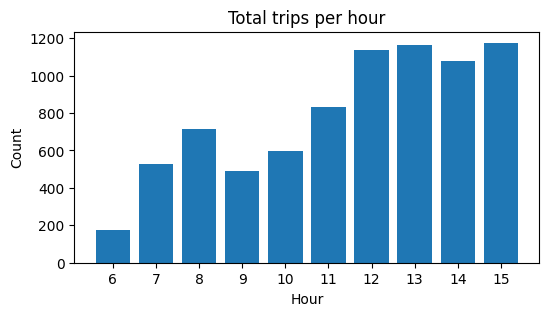

In [25]:
plt.figure(figsize=(6, 3))
plt.bar(range(len(hours)), X.sum(axis=(0, 1)))
plt.xticks(range(len(hours)), hours)
plt.title('Total trips per hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()


## Phase 2: Simplified Zip-dLBM
We implement:
- A small MLP for the ODE drift.
- Euler integration for dynamics.
- VEM updates for (tau, eta, delta).
- M-step updates for Lambda and neural dynamics.

Comments in code link each block to equations in the paper.


In [7]:
class SimpleMLP(nn.Module):
    def __init__(self, dim, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden)
        self.fc2 = nn.Linear(hidden, dim)

    def forward(self, x):
        return self.fc2(F.tanh(self.fc1(x)))


def euler_rollout(f, x0, steps):
    # ODE: x_{t+1} = x_t + f(x_t) (Euler, dt=1)
    xs = [x0]
    x = x0
    for _ in range(1, steps):
        x = x + f(x)
        xs.append(x)
    return torch.stack(xs, dim=0)


class ZipDLBM:
    def __init__(self, Q, L, max_em_iter=5, nn_epochs=100, lr=1e-2):
        self.Q = Q
        self.L = L
        self.max_em_iter = max_em_iter
        self.nn_epochs = nn_epochs
        self.lr = lr

        self.alpha_net = SimpleMLP(Q)
        self.beta_net = SimpleMLP(L)
        self.pi_net = SimpleMLP(1)

        self.alpha0 = nn.Parameter(torch.zeros(Q))
        self.beta0 = nn.Parameter(torch.zeros(L))
        self.pi0 = nn.Parameter(torch.zeros(1))

    def _rollout_params(self, T):
        a = euler_rollout(self.alpha_net, self.alpha0, T)
        b = euler_rollout(self.beta_net, self.beta0, T)
        c = euler_rollout(self.pi_net, self.pi0, T)
        alpha = F.softmax(a, dim=1)
        beta = F.softmax(b, dim=1)
        pi = torch.sigmoid(c).squeeze(1)
        return alpha, beta, pi

    def _ve_step(self, X, alpha, beta, pi, Lambda):
        N, M, T = X.shape
        Q, L = self.Q, self.L

        tau = np.zeros((N, Q, T))
        eta = np.zeros((M, L, T))
        delta = np.zeros((N, M, T))

        log_lambda = np.log(Lambda + 1e-16)
        for t in range(T):
            alpha_t = alpha[t].detach().cpu().numpy()
            beta_t = beta[t].detach().cpu().numpy()
            pi_t = pi[t].detach().cpu().numpy()

            # Initialize tau/eta with current priors
            tau[:, :, t] = np.random.dirichlet(alpha_t, size=N)
            eta[:, :, t] = np.random.dirichlet(beta_t, size=M)

            # Update delta (Eq. for structural zero probability)
            expected_lambda = tau[:, :, t] @ Lambda @ eta[:, :, t].T
            logit = np.log(pi_t + 1e-16) - np.log(1 - pi_t + 1e-16) + expected_lambda
            delta[:, :, t] = 1 / (1 + np.exp(-logit))
            delta[:, :, t][X[:, :, t] > 0] = 0.0

            # Update tau (Eq. for row membership)
            X_t = X[:, :, t]
            mat_R = (X_t * (1 - delta[:, :, t])) @ eta[:, :, t] @ log_lambda.T
            mat_R -= ((1 - delta[:, :, t])) @ eta[:, :, t] @ Lambda.T
            mat_R += np.log(alpha_t + 1e-16)
            mat_R = mat_R - mat_R.max(axis=1, keepdims=True)
            tau[:, :, t] = np.exp(mat_R)
            tau[:, :, t] /= tau[:, :, t].sum(axis=1, keepdims=True)

            # Update eta (Eq. for column membership)
            mat_S = (X_t * (1 - delta[:, :, t])).T @ tau[:, :, t] @ log_lambda
            mat_S -= ((1 - delta[:, :, t])).T @ tau[:, :, t] @ Lambda
            mat_S += np.log(beta_t + 1e-16)
            mat_S = mat_S - mat_S.max(axis=1, keepdims=True)
            eta[:, :, t] = np.exp(mat_S)
            eta[:, :, t] /= eta[:, :, t].sum(axis=1, keepdims=True)

        return tau, eta, delta

    def _m_step_lambda(self, X, tau, eta, delta):
        Q, L = self.Q, self.L
        num = np.zeros((Q, L))
        den = np.zeros((Q, L))
        for t in range(X.shape[2]):
            X_t = X[:, :, t]
            tau_t = tau[:, :, t]
            eta_t = eta[:, :, t]
            delta_t = delta[:, :, t]
            weight = (1 - delta_t)
            num += tau_t.T @ (X_t * weight) @ eta_t
            den += tau_t.T @ weight @ eta_t
        return num / (den + 1e-16)

    def _dynamics_loss(self, tau, eta, delta):
        T = tau.shape[2]
        alpha, beta, pi = self._rollout_params(T)

        tau_sum = torch.tensor(tau.sum(axis=0).T, dtype=torch.float32)
        eta_sum = torch.tensor(eta.sum(axis=0).T, dtype=torch.float32)
        delta_sum = torch.tensor(delta.sum(axis=(0, 1)), dtype=torch.float32)
        total = torch.tensor(delta.shape[0] * delta.shape[1], dtype=torch.float32)

        # Negative expected log-likelihood for alpha, beta, pi (VE/M-step formulas)
        loss_alpha = -torch.sum(tau_sum * torch.log(alpha + 1e-16))
        loss_beta = -torch.sum(eta_sum * torch.log(beta + 1e-16))
        pi_term = delta_sum * torch.log(pi + 1e-16) + (total - delta_sum) * torch.log(1 - pi + 1e-16)
        loss_pi = -torch.sum(pi_term)
        return loss_alpha + loss_beta + loss_pi

    def fit(self, X):
        N, M, T = X.shape
        Lambda = np.random.rand(self.Q, self.L) + 0.5

        opt = torch.optim.Adam(
            list(self.alpha_net.parameters()) +
            list(self.beta_net.parameters()) +
            list(self.pi_net.parameters()) +
            [self.alpha0, self.beta0, self.pi0],
            lr=self.lr,
        )

        elbo_trace = []

        for em in range(self.max_em_iter):
            alpha, beta, pi = self._rollout_params(T)
            tau, eta, delta = self._ve_step(X, alpha, beta, pi, Lambda)
            Lambda = self._m_step_lambda(X, tau, eta, delta)

            # M-step for dynamics via SGD
            for _ in range(self.nn_epochs):
                opt.zero_grad()
                loss = self._dynamics_loss(tau, eta, delta)
                loss.backward()
                opt.step()

            elbo_trace.append(-float(loss.detach().cpu().numpy()))
            print(f'EM {em+1}/{self.max_em_iter} - dyn loss: {float(loss):.3f}')

        self.tau = tau
        self.eta = eta
        self.delta = delta
        self.Lambda = Lambda
        self.alpha, self.beta, self.pi = self._rollout_params(T)
        return elbo_trace


/tmp/ipykernel_99496/1066093296.py:146: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print(f'EM {em+1}/{self.max_em_iter} - dyn loss: {float(loss):.3f}')


EM 1/4 - dyn loss: 21680.957
EM 2/4 - dyn loss: 23469.652
EM 3/4 - dyn loss: 24846.664
EM 4/4 - dyn loss: 25103.084


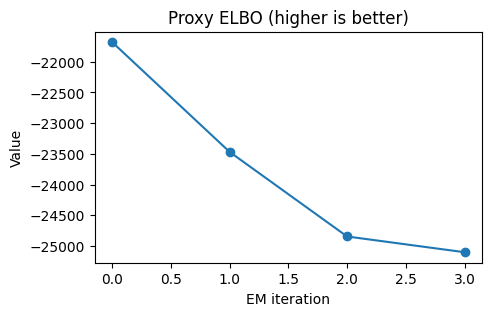

In [8]:
# Fit the simplified model
Q, L = 3, 3
model = ZipDLBM(Q=Q, L=L, max_em_iter=4, nn_epochs=50, lr=1e-2)
elbo_trace = model.fit(X)

plt.figure(figsize=(5, 3))
plt.plot(elbo_trace, marker='o')
plt.title('Proxy ELBO (higher is better)')
plt.xlabel('EM iteration')
plt.ylabel('Value')
plt.show()


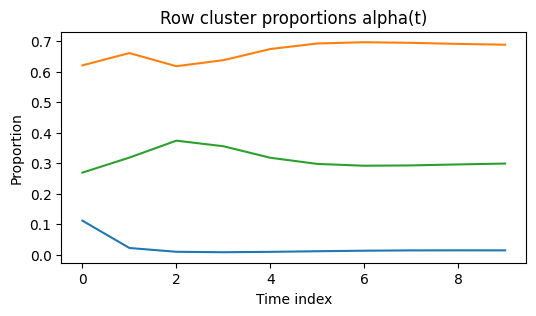

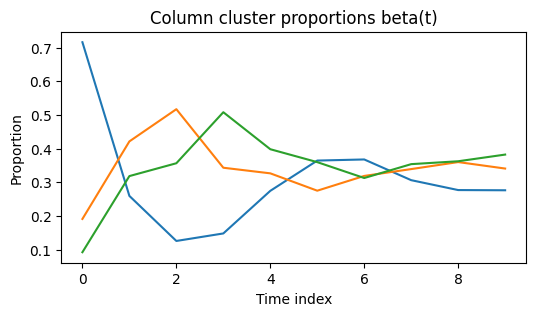

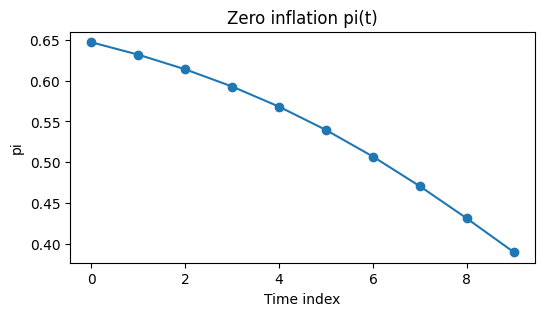

In [9]:
# Visualize dynamics
alpha = model.alpha.detach().cpu().numpy()
beta = model.beta.detach().cpu().numpy()
pi = model.pi.detach().cpu().numpy()

plt.figure(figsize=(6, 3))
plt.plot(alpha)
plt.title('Row cluster proportions alpha(t)')
plt.xlabel('Time index')
plt.ylabel('Proportion')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(beta)
plt.title('Column cluster proportions beta(t)')
plt.xlabel('Time index')
plt.ylabel('Proportion')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(pi, marker='o')
plt.title('Zero inflation pi(t)')
plt.xlabel('Time index')
plt.ylabel('pi')
plt.show()


In [10]:
# Interpret clusters for selected time steps
def top_entities_by_cluster(prob_matrix, names, top_k=5):
    labels = prob_matrix.argmax(axis=1)
    out = {}
    for k in range(prob_matrix.shape[1]):
        members = [names[i] for i in range(len(names)) if labels[i] == k]
        out[k] = members[:top_k]
    return out

t0 = 0
t1 = X.shape[2] - 1

tau_t0 = model.tau[:, :, t0]
tau_t1 = model.tau[:, :, t1]
eta_t0 = model.eta[:, :, t0]
eta_t1 = model.eta[:, :, t1]

print('Row clusters at early time:', top_entities_by_cluster(tau_t0, start_names))
print('Row clusters at late time:', top_entities_by_cluster(tau_t1, start_names))
print('Column clusters at early time:', top_entities_by_cluster(eta_t0, end_names))
print('Column clusters at late time:', top_entities_by_cluster(eta_t1, end_names))


Row clusters at early time: {0: [], 1: ['Albert Gate, Hyde Park', 'Allington Street, Victoria', 'Aquatic Centre, Queen Elizabeth Olympic Park', 'Battersea Power Station, Battersea Park', 'Bayswater Road, Hyde Park'], 2: ["Storey's Gate, Westminster", 'Tower Gardens , Tower', 'Wormwood Street, Liverpool Street']}
Row clusters at late time: {0: ['Aquatic Centre, Queen Elizabeth Olympic Park'], 1: ['Allington Street, Victoria', 'Battersea Power Station, Battersea Park', "Belgrove Street , King's Cross", 'Bethnal Green Road, Shoreditch', "Blackfriars Station, St. Paul's"], 2: ['Albert Gate, Hyde Park', 'Bayswater Road, Hyde Park', 'Black Lion Gate, Kensington Gardens', 'Brushfield Street, Liverpool Street', 'Duke Street Hill, London Bridge']}
Column clusters at early time: {0: ['Albert Gate, Hyde Park', 'Aquatic Centre, Queen Elizabeth Olympic Park', 'Battersea Power Station, Battersea Park', 'Bayswater Road, Hyde Park', "Belgrove Street , King's Cross"], 1: ['Brushfield Street, Liverpool 